# The Bellman Equation: Simplify Our Value Estimation

##**Bellman equation question: If I do this move, will it lead me to win?**

The Bellman equation **simplifies our state value or state-action value
calculation.**

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman.jpg)

With what we have learned so far, we know that if we calculate
\\(V(S_t)\\) (the value of a state), we need to calculate the return
starting at that state and then follow the policy forever after. **(The
policy we defined in the following example is a Greedy Policy; for
simplification, we don’t discount the reward).**

So to calculate \\(V(S_t)\\), we need to calculate the sum of the
expected rewards. Hence:

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman2.jpg)

*To calculate the value of State 1: the sum of rewards if the agent
started in that state and then followed the greedy policy (taking
actions that lead to the best state values) for all the time steps.*

Then, to calculate the \\(V(S\_{t+1})\\), we need to calculate the
return starting at that state \\(S\_{t+1}\\).

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman3.jpg)

*To calculate the value of State 2: the sum of rewards **if the agent
started in that state**, and then followed the **policy for all the time
steps.***

So you may have noticed, we’re repeating the computation of the value of
different states, which can be tedious if you need to do it for each
state value or state-action value.

Instead of calculating the expected return for each state or each
state-action pair, **we can use the Bellman equation**. (Hint: if you
know what Dynamic Programming is, this is very similar! If you don’t
know what it is, no worries!)

The Bellman equation is a recursive equation that works like this:
instead of starting for each state from the beginning and calculating
the return, we can consider the value of any state as:

**The immediate reward \\(R\_{t+1}\\) + the discounted value of the
state that follows ( \\(V(S\_{t+1}) \\) ) .**

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman4.jpg)

If we go back to our example, we can say that the value of State 1 is
equal to the expected cumulative return if we start at that state.

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman2.jpg)

To calculate the value of State 1: the sum of rewards **if the agent
started in that state 1** and then followed the **policy for all the
time steps.**

This is equivalent to \\(V(S\_{t})\\) = Immediate reward
\\(R\_{t+1}\\) + Discounted value of the next state \\(V(S\_{t+1})\\)

![Bellman
equation](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/bellman6.jpg)

*For simplification, here we don’t discount so gamma = 1.*

In the interest of simplicity, here we don’t discount, so gamma = 1. But
you’ll study an example with gamma = 0.99 in the Q-Learning section of
this unit.

-   The value of \\(V(S\_{t+1}) \\) = Immediate reward \\(R\_{t+2}\\) +
    Discounted value of the next state ( \\(V(S\_{t+2})\\) ).
-   And so on.

To recap, the idea of the Bellman equation is that instead of
calculating each value as the sum of the expected return, **which is a
long process**, we calculate the value as **the sum of immediate
reward + the discounted value of the state that follows.**

Before going to the next section, think about the role of gamma in the
Bellman equation. What happens if the value of gamma is very low (e.g.,
0.1 or even 0)? What happens if the value is 1? What happens if the
value is very high, such as a million?

# Policy Iteration with Bellman Equation on FrozenLake

This notebook implements policy iteration using the Bellman equation on the FrozenLake-v1 environment from OpenAI Gym. We'll use pure policy iteration without Q-learning.

In [ ]:
import numpy as np
import gym
from gym.wrappers import RecordVideo
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from IPython import display
import glob
import base64

In [ ]:
class PolicyIterator:
    def __init__(self, env, gamma=0.99, theta=1e-8):
        self.env = env
        self.gamma = gamma  # discount factor
        self.theta = theta  # convergence threshold

        # Initialize value function and policy
        self.num_states = env.observation_space.n  #gets the number of states
        self.num_actions = env.action_space.n  #gets the number of actions
        self.V = np.zeros(self.num_states)  #initial belief about value of each state
        # Start with a random policy
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions

    def policy_evaluation(self):
        """Evaluate policy using Bellman equation until convergence"""
        while True:
            delta = 0  #to track maximum changes
            # For each state
            for s in range(self.num_states):  #Iterates over each state
                v = self.V[s]  #old value of state
                new_v = 0

                # Applying Bellman equation
                for a in range(self.num_actions):  #looping through all actions
                    for prob, next_state, reward, done in self.env.P[s][a]:  #and thier possible next state, rewards, and probabilties
                        new_v += self.policy[s][a] * prob * (reward + self.gamma * self.V[next_state] * (not done))  #loops until done = true

                self.V[s] = new_v  #updates state value
                delta = max(delta, abs(v - self.V[s]))  #choose the max

            if delta < self.theta:
                break

    def policy_improvement(self):
        """Improve policy based on current value function"""
        policy_stable = True

        for s in range(self.num_states):
            old_action = np.argmax(self.policy[s])  #checks if the action has changed
            action_values = np.zeros(self.num_actions)  #stores each action values of the current state

            # Find the best action using Bellman equation
            for a in range(self.num_actions):
                for prob, next_state, reward, done in self.env.P[s][a]:
                    action_values[a] += prob * (reward + self.gamma * self.V[next_state] * (not done))

            # Update policy to choose the best action
            best_action = np.argmax(action_values)
            self.policy[s] = np.eye(self.num_actions)[best_action] #updates the policy with the best action

            if old_action != best_action:
                policy_stable = False

        return policy_stable

    def run_policy_iteration(self, max_iterations=1000):
        """Run the complete policy iteration algorithm"""
        for i in range(max_iterations):
            # 1. Evaluate current policy
            self.policy_evaluation()

            # 2. Improve policy
            policy_stable = self.policy_improvement()

            print(f"Iteration {i+1} completed")

            if policy_stable:
                print(f"\nPolicy converged after {i+1} iterations")
                break

        return self.policy, self.V

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def run_episode(env, policy, render=False):   #to see how well it preforms
    """Run one episode using the given policy"""
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done:
        if render:  #if true dispaly each step of the episode
            env.render()
            time.sleep(0.5)

        action = np.argmax(policy[state]) #choose the action suggested by the policy for the current state
        state, reward, done, _ = env.step(action)
        total_reward += reward
        steps += 1

        if steps > 100:  #if the agent is stuck and cant reach its goal
            break

    return total_reward, steps

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Iteration 1 completed
Iteration 2 completed
Iteration 3 completed

Policy converged after 3 iterations


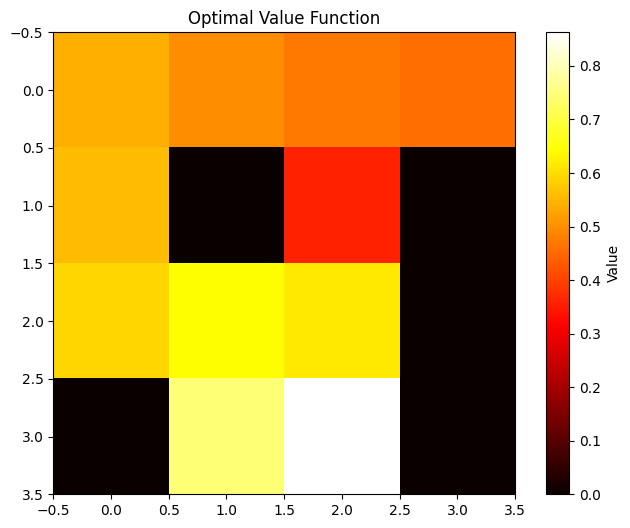


Optimal Policy:
[['←' '↑' '↑' '↑']
 ['←' '←' '←' '←']
 ['↑' '↓' '←' '←']
 ['←' '→' '↓' '←']]


In [ ]:
# Create environment
env = gym.make('FrozenLake-v1', is_slippery=True)

# Initialize and run policy iteration
pi = PolicyIterator(env)
optimal_policy, optimal_value = pi.run_policy_iteration()

# Visualize the optimal value function
plt.figure(figsize=(8, 6))
plt.imshow(optimal_value.reshape(4, 4), cmap='hot')
plt.colorbar(label='Value')
plt.title('Optimal Value Function')
plt.show()

# Display the optimal policy in a readable format
action_symbols = ['←', '↓', '→', '↑']
policy_grid = np.array([[action_symbols[np.argmax(optimal_policy[i])] for i in range(16)]]).reshape(4, 4)
print("\nOptimal Policy:")
print(policy_grid)

In [ ]:
# Record video of the trained policy
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode='rgb_array')
env = RecordVideo(env, './video/FrozenLake-v1')

# Run and record episodes
for episode in range(5):
    reward, steps = run_episode(env, optimal_policy)
    print(f"Episode {episode + 1}: Reward = {reward}, Steps = {steps}")

env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Reward = 1.0, Steps = 21
Episode 2: Reward = 1.0, Steps = 51
Episode 3: Reward = 1.0, Steps = 66
Episode 4: Reward = 1.0, Steps = 12
Episode 5: Reward = 1.0, Steps = 16


In [ ]:
def show_video():
    """Display video of agent's performance"""
    mp4list = glob.glob('video/FrozenLake-v1/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = open(mp4, 'rb').read()
        base64_encoded = base64.b64encode(video)
        return HTML(f"""
        <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{base64_encoded.decode()}" type="video/mp4">
        </video>""")
    else:
        print("Could not find video")

# Display the video
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Lab Task**

**Objective:** Implement value iteration in a 4x4 grid to calculate optimal values for each state using the Bellman equation.

**Environment Setup:**

* Create a 4x4 grid.
* Define a reward of +1 in the bottom-right cell (goal state).
* Set penalties of -1 in one or two cells (obstacles).
* All other states have a reward of 0.
* Use a discount factor (γ) of 0.9.

**Instructions:**

* Initialize a value matrix
𝑉
V with zeros.
Update values using the Bellman equation

* Iterate until values stabilize (change < 0.01).
* Determine the optimal policy by choosing the best action leading to the highest value state.

**Bonus:** Experiment with different discount factors (e.g., 0.8, 0.95).

## **Refrences**

https://github.com/huggingface/deep-rl-class/blob/main/units/en/unit2/bellman-equation.mdx

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid world environment
class GridWorld:
    def __init__(self, size=4, goal=(3, 3), obstacles=[(1, 1), (2, 2)], gamma=0.9):
        self.size = size
        self.goal = goal
        self.obstacles = obstacles
        self.gamma = gamma
        self.rewards = np.zeros((size, size))
        self.rewards[goal] = 1
        for obs in obstacles:
            self.rewards[obs] = -1

    def get_actions(self, state):
        """Returns possible actions and corresponding next states and rewards"""
        actions = {}
        x, y = state
        # Define possible moves: left, right, up, down
        moves = {'left': (x, max(y - 1, 0)), 'right': (x, min(y + 1, self.size - 1)),
                 'up': (max(x - 1, 0), y), 'down': (min(x + 1, self.size - 1), y)}

        for action, new_state in moves.items():
            reward = self.rewards[new_state]
            actions[action] = (new_state, reward)
        return actions

# Value Iteration Algorithm
def value_iteration(env, theta=0.01):
    V = np.zeros((env.size, env.size))
    delta = float("inf")

    while delta >= theta:
        delta = 0
        for i in range(env.size):
            for j in range(env.size):
                if (i, j) == env.goal:
                    continue  # Skip the goal state

                v = V[i, j]
                max_value = float("-inf")

                # Apply Bellman equation to find the optimal value
                for action, (next_state, reward) in env.get_actions((i, j)).items():
                    next_value = reward + env.gamma * V[next_state]
                    max_value = max(max_value, next_value)

                V[i, j] = max_value
                delta = max(delta, abs(v - V[i, j]))

    return V

# Deriving the optimal policy
def derive_policy(env, V):
    policy = np.full((env.size, env.size), ' ')
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) == env.goal:
                policy[i, j] = 'G'  # Goal
                continue

            max_value = float("-inf")
            best_action = None

            for action, (next_state, reward) in env.get_actions((i, j)).items():
                next_value = reward + env.gamma * V[next_state]
                if next_value > max_value:
                    max_value = next_value
                    best_action = action

            policy[i, j] = best_action[0].upper() if best_action else ' '

    return policy

# Experimentation function to test different discount factors
def experiment(gamma_values):
    for gamma in gamma_values:
        print(f"\nDiscount Factor: {gamma}")
        env = GridWorld(gamma=gamma)
        optimal_values = value_iteration(env)
        optimal_policy = derive_policy(env, optimal_values)

        # Display results
        print("\nOptimal Value Function:")
        print(optimal_values)
        print("\nOptimal Policy:")
        print(optimal_policy)

# Define environment and perform value iteration
gamma = 0.9
env = GridWorld(gamma=gamma)
optimal_values = value_iteration(env)
optimal_policy = derive_policy(env, optimal_values)

# Display results
print("Optimal Value Function:")
print(optimal_values)

print("\nOptimal Policy:")
for row in optimal_policy:
    print(' '.join(row))

# Experiment with different discount factors
experiment([0.8, 0.9, 0.95])

Optimal Value Function:
[[0.59049 0.6561  0.729   0.81   ]
 [0.6561  0.729   0.81    0.9    ]
 [0.729   0.81    0.9     1.     ]
 [0.81    0.9     1.      0.     ]]

Optimal Policy:
R R R D
D R R D
R D R D
R R R G

Discount Factor: 0.8

Optimal Value Function:
[[0.32768 0.4096  0.512   0.64   ]
 [0.4096  0.512   0.64    0.8    ]
 [0.512   0.64    0.8     1.     ]
 [0.64    0.8     1.      0.     ]]

Optimal Policy:
[['R' 'R' 'R' 'D']
 ['D' 'R' 'R' 'D']
 ['R' 'D' 'R' 'D']
 ['R' 'R' 'R' 'G']]

Discount Factor: 0.9

Optimal Value Function:
[[0.59049 0.6561  0.729   0.81   ]
 [0.6561  0.729   0.81    0.9    ]
 [0.729   0.81    0.9     1.     ]
 [0.81    0.9     1.      0.     ]]

Optimal Policy:
[['R' 'R' 'R' 'D']
 ['D' 'R' 'R' 'D']
 ['R' 'D' 'R' 'D']
 ['R' 'R' 'R' 'G']]

Discount Factor: 0.95

Optimal Value Function:
[[0.77378094 0.81450625 0.857375   0.9025    ]
 [0.81450625 0.857375   0.9025     0.95      ]
 [0.857375   0.9025     0.95       1.        ]
 [0.9025     0.95       1.       


Discount Factor: 0.8

Optimal Value Function:
[[0.32768 0.4096  0.512   0.64   ]
 [0.4096  0.512   0.64    0.8    ]
 [0.512   0.64    0.8     1.     ]
 [0.64    0.8     1.      0.     ]]

Optimal Policy:
R R R D
D R R D
R D R D
R R R G


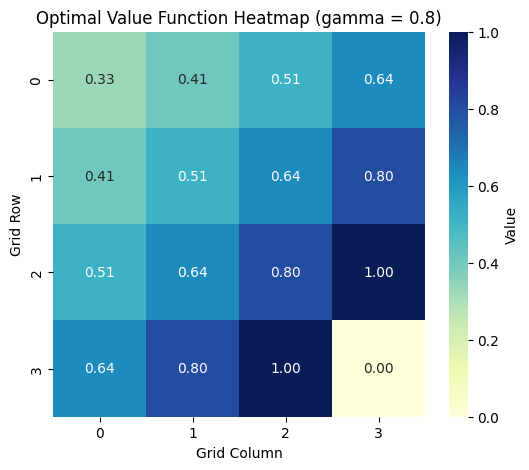


Discount Factor: 0.9

Optimal Value Function:
[[0.59049 0.6561  0.729   0.81   ]
 [0.6561  0.729   0.81    0.9    ]
 [0.729   0.81    0.9     1.     ]
 [0.81    0.9     1.      0.     ]]

Optimal Policy:
R R R D
D R R D
R D R D
R R R G


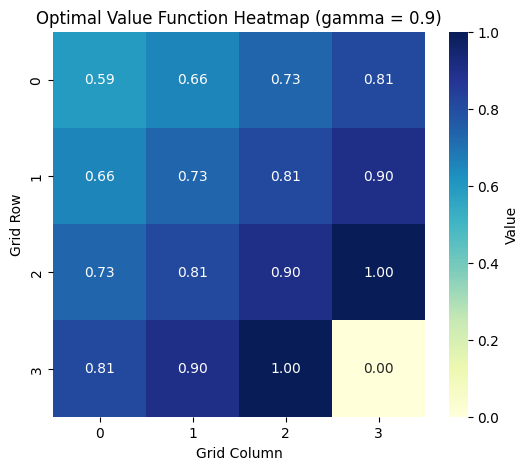


Discount Factor: 0.95

Optimal Value Function:
[[0.77378094 0.81450625 0.857375   0.9025    ]
 [0.81450625 0.857375   0.9025     0.95      ]
 [0.857375   0.9025     0.95       1.        ]
 [0.9025     0.95       1.         0.        ]]

Optimal Policy:
R R R D
D R R D
R D R D
R R R G


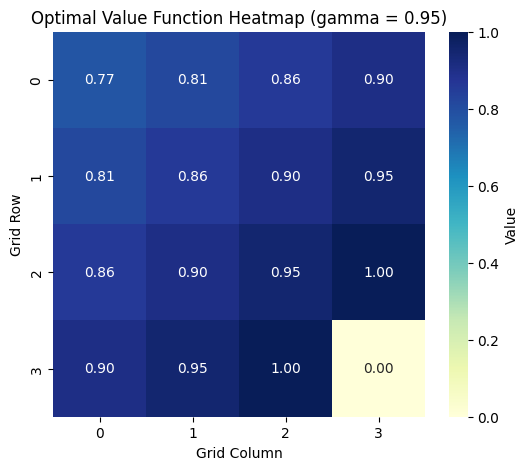

In [ ]:
import seaborn as sns
# Experimentation function with heatmap visualization
def experiment_with_heatmaps(gamma_values):
    for gamma in gamma_values:
        print(f"\nDiscount Factor: {gamma}")
        env = GridWorld(gamma=gamma)
        optimal_values = value_iteration(env)
        optimal_policy = derive_policy(env, optimal_values)

        # Display results
        print("\nOptimal Value Function:")
        print(optimal_values)
        print("\nOptimal Policy:")
        for row in optimal_policy:
            print(' '.join(row))

        # Plot heatmap for the optimal value function
        plt.figure(figsize=(6, 5))
        sns.heatmap(optimal_values, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Value'})
        plt.title(f'Optimal Value Function Heatmap (gamma = {gamma})')
        plt.xlabel("Grid Column")
        plt.ylabel("Grid Row")
        plt.show()

# Run experiments with different discount factors and visualize heatmaps
experiment_with_heatmaps([0.8, 0.9, 0.95])